#### Lab 5 - Análisis de tráfico, implementación de un IDS

### Parte 1

In [9]:
from scapy.all import *
import pandas as pd 
import numpy as np 
import binascii
import seaborn as sns
sns.set(color_codes = True)
%matplotlib inline

In [10]:
amount_of_packets = 100
pcap = sniff(count = amount_of_packets)
print("Tipo del pcap: ",type(pcap))
print("Largo del pcap: ", len(pcap))
print(pcap)

Tipo del pcap:  <class 'scapy.plist.PacketList'>
Largo del pcap:  100
<Sniffed: TCP:99 UDP:1 ICMP:0 Other:0>


In [11]:
path = 'analisis_paquetes.pcap'
archivo = rdpcap(path)

In [12]:
pcap = pcap + archivo

In [13]:
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

dataframe_fields = ip_fields + ["time"] + tcp_fields + ['payload','payload_raw','payload_hex']

df = pd.DataFrame(columns = dataframe_fields)

for packet in pcap[IP]:
    field_values = []
    for field in ip_fields:
        if field == "options":
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    field_values.append(packet.time)
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field =="options":
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

df = df.reset_index()
df = df.drop(columns="index")
df.head()

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,87,0,DF,0,64,6,27423,...,8,0,PA,2046,39229,0,3,35,"b'\x17\x03\x03\x00\x1ey\xfc\xb1L\x9f\xbe\xf7,a...",b'170303001e79fcb14c9fbef72c61f820fd8d70f2581e...
1,4,5,0,83,6179,DF,0,39,6,27648,...,8,0,PA,8,25941,0,3,31,b'\x17\x03\x03\x00\x1a\xb8h1\xb0\xb4\xf5\x86\x...,b'170303001ab86831b0b4f58699da8ae7b6725f213bf2...
2,4,5,0,52,0,DF,0,64,6,27458,...,8,0,A,2046,27333,0,3,0,b'',b''
3,4,5,0,64,0,DF,0,64,6,25126,...,11,0,S,65535,10461,0,8,0,b'',b''
4,4,5,0,52,42810,DF,0,106,6,37111,...,8,0,SA,65535,44329,0,6,0,b'',b''


In [14]:
top = df['src'].describe()['top']
df['dst'].describe()['top']
df['dst'][df['src'] == top].value_counts()
df['dport'][df['src'] == top].value_counts()
df['sport'][df['src'] == top].value_counts()

56816    13
56817    13
56818    13
56767     3
56796     3
56768     3
65057     2
56118     2
56119     2
56770     2
56790     1
57621     1
56781     1
Name: sport, dtype: int64

<AxesSubplot:xlabel='count', ylabel='src'>

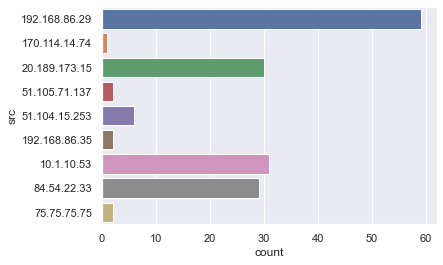

In [15]:
sns.countplot(
    data = df,
    y = 'src',
)

In [17]:
df_top = df[df['src'] == top]
top_talks_to = df_top['dst'].unique()
df_top['dst'].value_counts()
suspicious = top_talks_to[0]
df_sus = df_top[df_top["dst"]== suspicious]
array = df_sus['payload_raw'].to_numpy()

In [18]:
for i in array:
    print(i,"\n\n")

b'\x17\x03\x03\x00\x1ey\xfc\xb1L\x9f\xbe\xf7,a\xf8 \xfd\x8dp\xf2X\x1e\x91\x8e\xc1^\x01\xb0\x80\r\x1b-\x00i\xc6' 


b'' 




### Parte 2

In [20]:
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [21]:
trainDf = pd.read_csv("Train_data.csv")
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [22]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
trainDf["class"]= labelEncoder.fit_transform(trainDf["class"])
target = trainDf['class']
trainDf = trainDf.drop(columns=['class'])

In [ ]:
categoricalColumns = trainDf.select_dtypes(exclude=[np.number])